# 8-3 합성곱 신경망의 시각화
학습 목표 : 합성곱 층의 가중치와 특성 맵을 시각화하여 신경망이 이미지에서 어떤 것을 학습하는지 이해해 본다

핵심 키워드 : 가중치 시각화, 특성 맻 시각화, 함수형 API

## 가중치 시각화

훈련한 합성곱 신경망 만들기

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
# 데이터 불러오기
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)
model = keras.Sequential()
# 첫 번째 합성곱-폴링 층
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2))
# 두 번째 합성곱-폴링 층
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
# 완전 연결층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
# 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5348 - accuracy: 0.8107 - val_loss: 0.3549 - val_accuracy: 0.8656
Epoch 2/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3545 - accuracy: 0.8739 - val_loss: 0.2947 - val_accuracy: 0.8898
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3001 - accuracy: 0.8913 - val_loss: 0.2544 - val_accuracy: 0.9050
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2677 - accuracy: 0.9032 - val_loss: 0.2364 - val_accuracy: 0.9129
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2441 - accuracy: 0.9103 - val_loss: 0.2436 - val_accuracy: 0.9099
Epoch 6/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2272 - accuracy: 0.9167 - val_loss: 0.2276 - val_accuracy: 0.9169
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2080 - accuracy: 0.9247 - val_loss: 0.2150 - val_accuracy:

In [ ]:
model = keras.models.load_model('best-cnn-model.h5')

케라스 모델에 추가한 층은 layers 속성에 저장됨

In [ ]:
model.layers

### 훈련된 합성곱 층 가중치 출력
 - weights 속성 : 층의 가중치와 절편이 저장되어 있음

In [ ]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std()) # 평균, 표준편차

-0.013629958 0.23692125


### 층의 가중치 분포

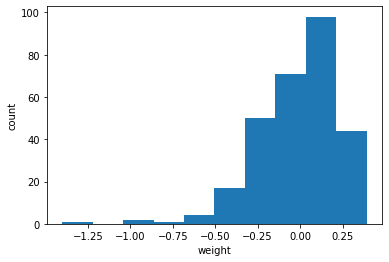

In [ ]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

### 층의 가중치 시각화

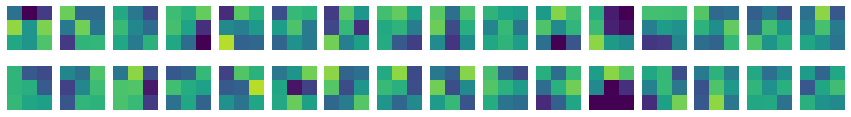

In [ ]:
fix, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i,j].axis('off')
plt.show()

conv_weights에 32개의 가중치가 저장되어 있음.

### 훈련하지 않은 빈 합성곱 신경망

In [ ]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.0022368669 0.084917136


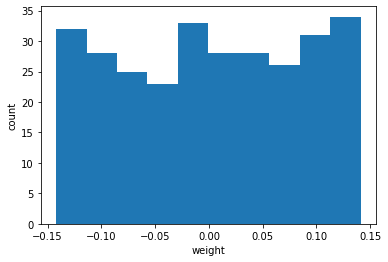

In [ ]:
import matplotlib.pyplot as plt
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

그래프가 이전과 확실히 다른 것을 볼 수 있다

비교적 고른 분포를 보임 - 텐서플로가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문

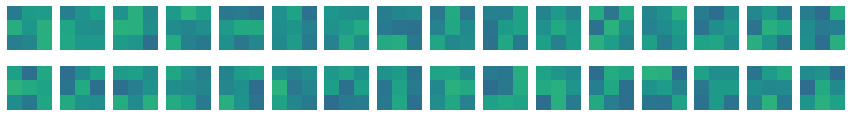

In [ ]:
fix, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i,j].axis('off')
plt.show()

## 함수형 API
- functional API
- 케라스의 Model 클래스 사용
- 다양한 구성으로 모델을 만들어볼수있음

아래 코드는 사용 예시

In [ ]:
# dense1 = keras.layers.Dense(100, activation='sigmoid')
# dense2 = keras.layers.Dense(10, activation='softmax')

# inputs = keras.Input(shape=(784,)) # InputLayer 클래스 객체 반환
# hidden = dense1(inputs)
# outputs = dense2(hidden)
# model = keras.Model(inputs, outputs)

In [ ]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_7_input'), name='conv2d_7_input', description="created by layer 'conv2d_7_input'")


In [ ]:
conv_acti = keras.Model(model.input, model.layers[0].output)

## 특성 맵 시각화

첫 번째 샘플 출력

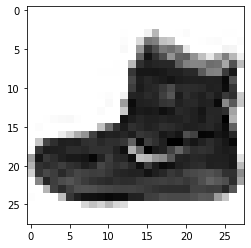

In [ ]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

### 첫 번째 합성곱 층이 만든 특성 맵 시각화

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [ ]:
print(feature_maps.shape)

(1, 28, 28, 32)


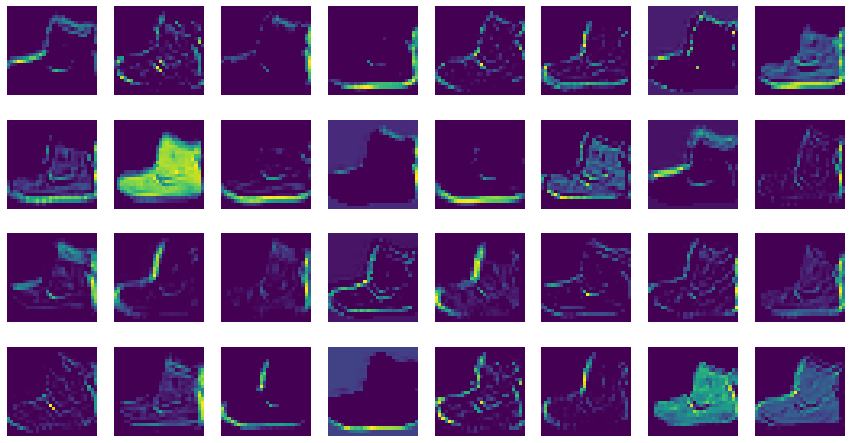

In [ ]:
fix, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i,j].axis('off')
plt.show()

### 두 번째 합성곱 층이 만든 특성 맵 시각화

In [ ]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [ ]:
print(feature_maps.shape)

(1, 14, 14, 64)


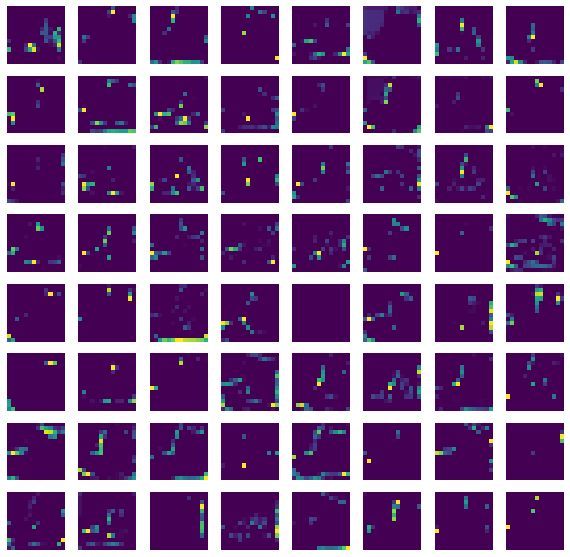

In [ ]:
fix, axs = plt.subplots(8, 8, figsize=(10,10))
for i in range(8):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i,j].axis('off')
plt.show()

합성곱 층의 특성 맵을 시각화해서 확인해보면 **저수준 층은 이해하기 쉽지만 고수준이 될수록 추상적으로 출력**되므로 이해하기 어렵다